## Figures S2-S3
Heat maps compare chromatin accessibility with gene expression levels and the intensity of epigenetic marks. The genes were ordered from highest to lowest guided by the correlation between acetylation and methylation fluxes (Acetyl-CoA/SAM) and the H3K9Ac/H3K4me3 epigenetic marks.

In [1]:
import pandas as pd
import numpy as np
import cobra
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.interpolate import interp1d
import requests
import time
from scipy.stats import mannwhitneyu 

In [2]:
#RNA-seq from Kuang et al. (2014) 
fpkm=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/RNA_new/KuangRNAseq_15.csv",index_col=0)
#ATAC-seq from Gowans et al. (2018)
atac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/GSE101290_normalized_atac_counts.csv",index_col=0)
#stages YMC from Kuang et al. (2014)
OX= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangOX.txt", sep="\t")
RB= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRB.txt", sep="\t")
RC= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRC.txt", sep="\t")
#Fluxes of ACOA and SAM from Pheflux2.0
ACOA_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC_15_allflux.csv",index_col=0)
SAM_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME_15_allflux.csv",index_col=0)
#ChIP-seq from Kuang et al. (2014)
H3K9ac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_15_ac.csv", index_col=0)
H3K4me3=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_15_me.csv", index_col=0)

In [3]:
#Separate the lists of each stage
#Leave only RNA-seq columns and exclude microarray columns
df_fpkm=fpkm.iloc[0:-2,-16::] 

In [4]:
#Mean between the different elements of replicates 1, 2; 3. 4; 5, 6.
genes=atac.index
T1=list((atac.iloc[: , 1].values+atac.iloc[: , 2].values)/2)
T2=list((atac.iloc[: , 3].values+atac.iloc[: , 4].values)/2)
T3=list((atac.iloc[: , 5].values+atac.iloc[: , 6].values)/2)
T4=list((atac.iloc[: , 7].values+atac.iloc[: , 8].values)/2)
T5=list((atac.iloc[: , 9].values+atac.iloc[: , 10].values)/2)
T6=list((atac.iloc[: , 11].values+atac.iloc[: , 12].values)/2)

In [5]:
#Create df from the lists made with the averages of the replicates
lst1 = genes
lst2 = T2 # RC II
lst3= T3  # OX I
lst4= T4  # OX II
lst5= T5  # RB I
lst6= T6  # RB II
lst7= T1  # RC I
atac_prom = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5,lst6,lst7)), columns = ['Genes','T1','T2','T3','T4','T5','T6'])
#set the gene.id column as index to make the heatmap
df_atac = atac_prom.set_index(['Genes'])

In [6]:
#Define lists with genes by stage
lista_RC=list(RC.iloc[0:-2,0])
lista_OX=list(OX.iloc[0:-2,0])
lista_RB=list(RB.iloc[0:-2,0])

In [7]:
#Lists of stages in atac-seq
list_1=lista_RC
list_2=atac.index
from collections import Counter
cnt1 = Counter(list_1)
cnt2 = Counter(list_2)
lista_RB_ss= [key for key, counts in cnt2.items() if cnt1[key] == counts]

list_3=lista_OX
list_4=atac.index
from collections import Counter
cnt3 = Counter(list_3)
cnt4 = Counter(list_4)
lista_OX_ss= [key for key, counts in cnt4.items() if cnt3[key] == counts]

list_5=lista_RB
list_6=atac.index
from collections import Counter
cnt5 = Counter(list_5)
cnt6 = Counter(list_6)
lista_RB_ss= [key for key, counts in cnt6.items() if cnt5[key] == counts]

In [8]:
lista_RC_ss=[]
for gene in lista_RC:
    if gene in atac.index:
          lista_RC_ss.append(gene)

lista_OX_ss=[]
for gene in lista_OX:
    if gene in atac.index:
          lista_OX_ss.append(gene)
            
lista_RB_ss=[]
for gene in lista_RB:
    if gene in atac.index:
          lista_RB_ss.append(gene)

In [9]:
#Calculation of the correlation between the precursor and the epigenetic mark
def ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa):
    # subsets the dataframe
    df = marcaEpigenetica.loc[genesEtapa]
    # Computes the correlation
    corr=[]
    for i in range(len(df)):
        a = np.array(df.iloc[i,:])
        b = np.array(perfilPrecursor)[0]
        corr.append(stats.pearsonr(a,b)[0])
    #order correlation from highest to lowest
    df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
    corr_sort = df_corr.sort_values('correlation',ascending=False)

    return(corr_sort)

# Figure S2

RC



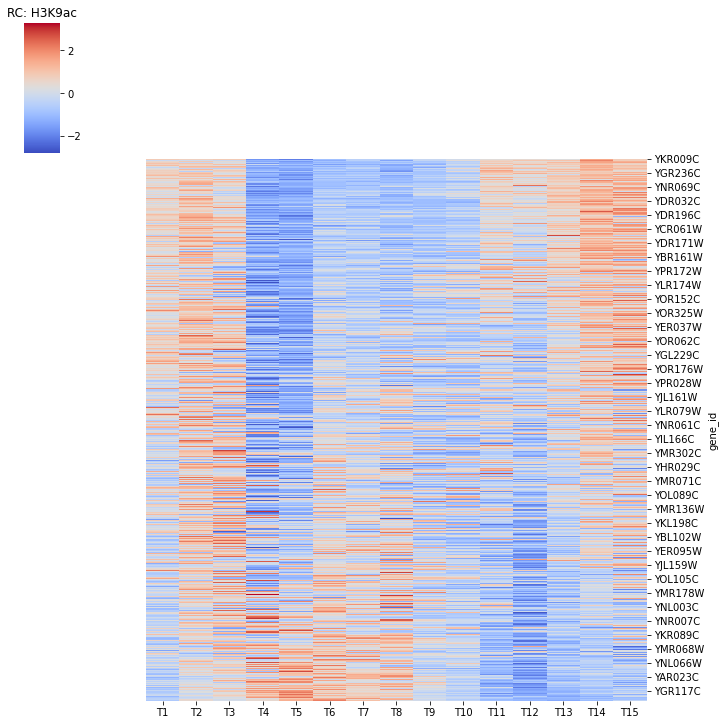

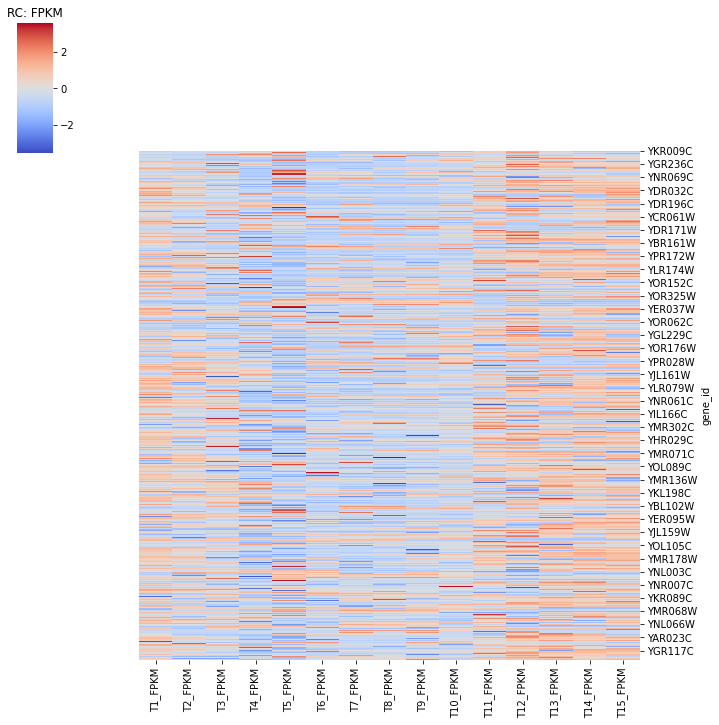

In [10]:
#H3K9Ac
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

for etapa in ["RC"]:
    print(etapa)
    print("=====================================================================\n")
    genesEtapa = {"RC":lista_RC_ss,"OX":lista_OX_ss,"RB":lista_RB_ss}[etapa]
    genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

    #H3K9Ac
    ACOA_H3K9ac=H3K9ac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    ax=sns.clustermap(ACOA_H3K9ac, cmap=sns.color_palette("coolwarm", as_cmap=True),col_cluster=False, row_cluster=False
    )
    plt.title(etapa+": H3K9ac")    
    plt.savefig(etapa+"_ACOA_H3K9ac.pdf")
    #FPKM
    ACOA_fpkm=fpkm.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    ax=sns.clustermap(ACOA_fpkm, cmap=sns.color_palette("coolwarm", as_cmap=True),col_cluster=False, row_cluster=False
    )
    plt.title(etapa+": FPKM")
    plt.savefig(etapa+"_fpkm_ac.pdf")

# Figure S3

OX

RB



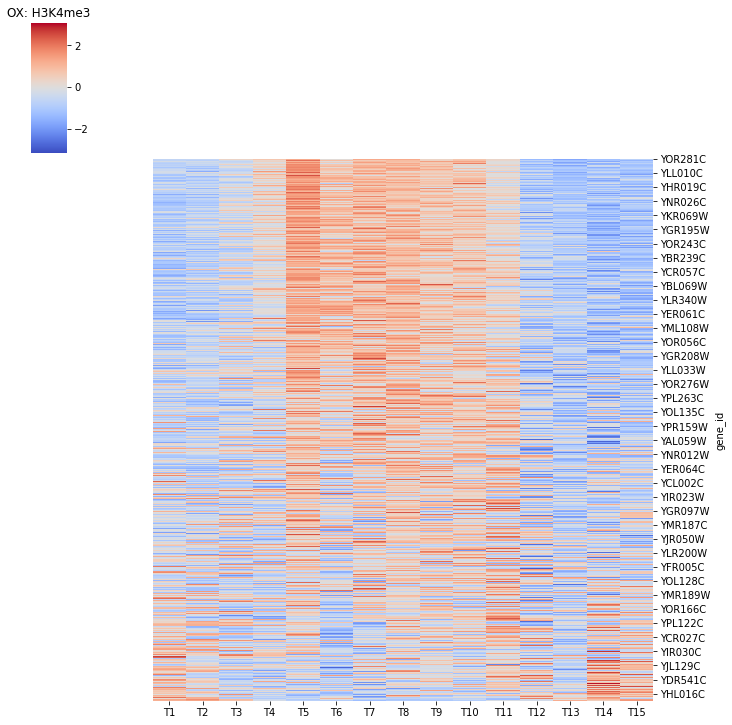

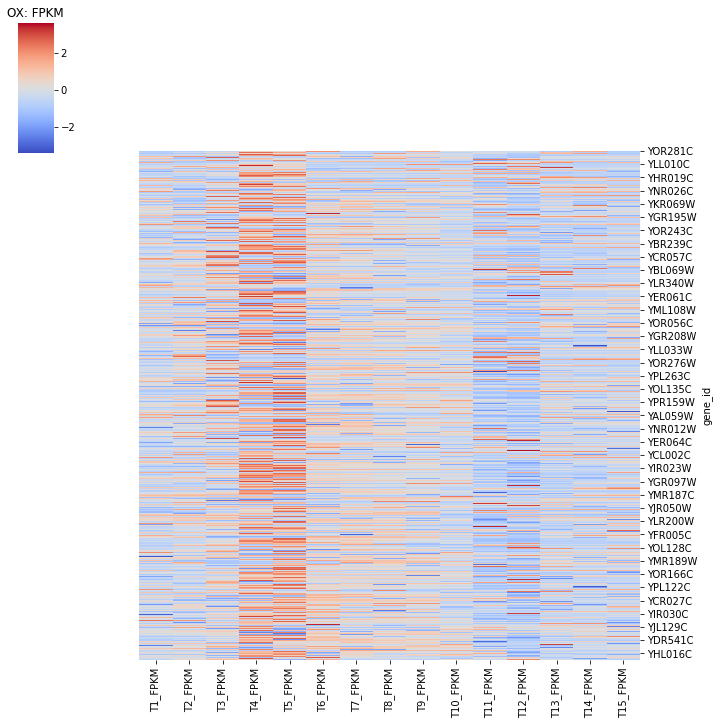

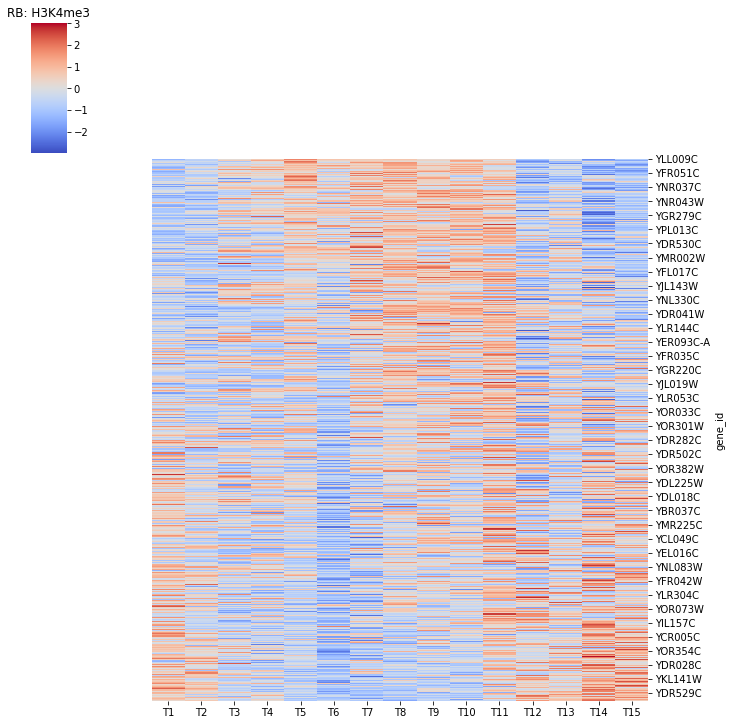

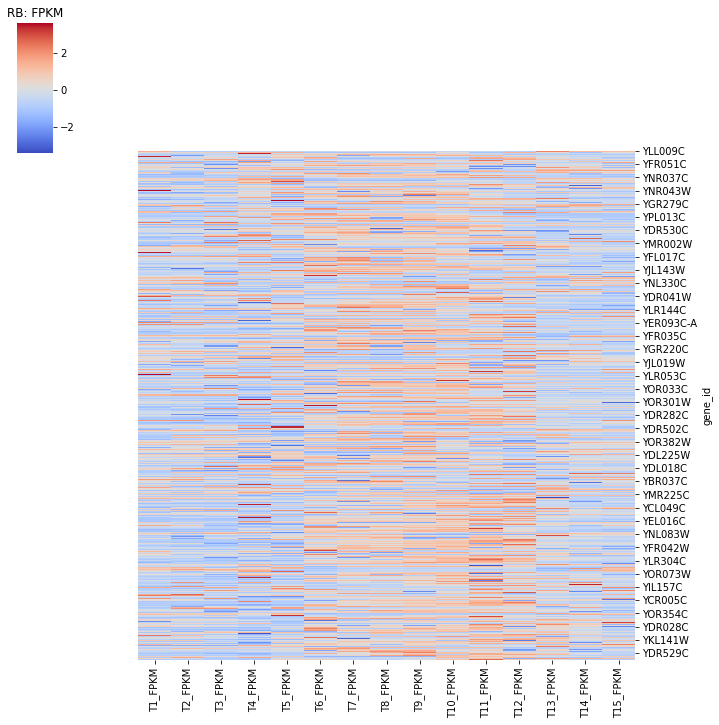

In [11]:
#H3K4me3
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

for etapa in ["OX","RB"]:
    print(etapa)
    print("=====================================================================\n")
    genesEtapa = {"RC":lista_RC_ss,"OX":lista_OX_ss,"RB":lista_RB_ss}[etapa]
    genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

    #H3K4me3
    SAM_H3K4me3=H3K4me3.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    ax=sns.clustermap(SAM_H3K4me3, cmap=sns.color_palette("coolwarm", as_cmap=True),col_cluster=False, row_cluster=False
    )
    plt.title(etapa+": H3K4me3")    
    plt.savefig(etapa+"_SAM_H3K4me3.pdf")
    #FPKM
    SAM_fpkm=fpkm.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
    ax=sns.clustermap(SAM_fpkm, cmap=sns.color_palette("coolwarm", as_cmap=True),col_cluster=False, row_cluster=False
    )
    plt.title(etapa+": FPKM")
    plt.savefig(etapa+"_SAM_fpkm.pdf")